# Drift detection

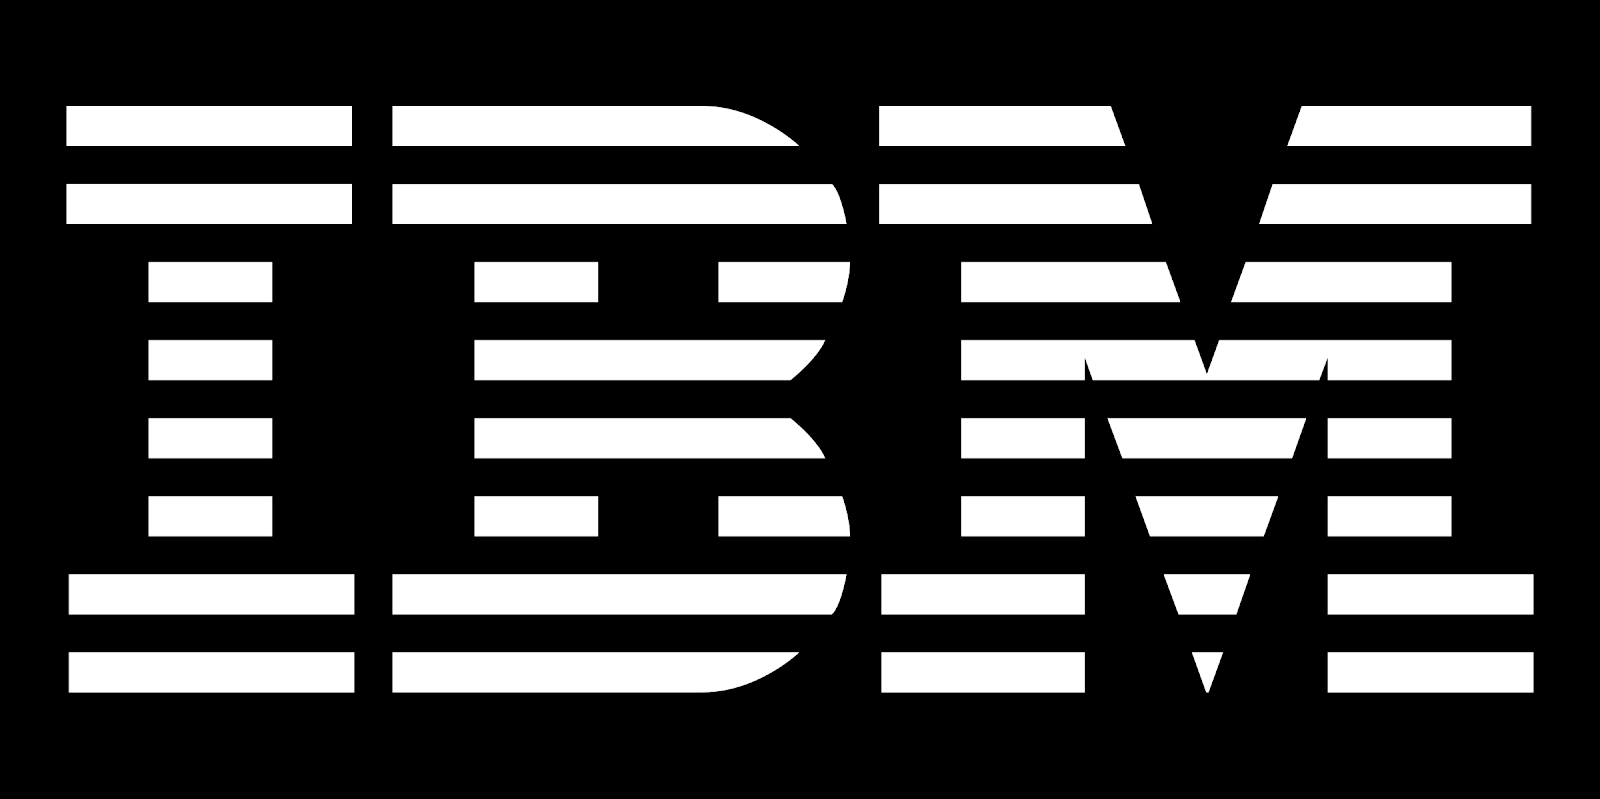


In [7]:
import re
import os
import sys
import time
import csv
import joblib
import uuid
from collections import Counter,defaultdict
import numpy as np
import pandas as pd
from termcolor import cprint
import matplotlib.pyplot as plt

from datetime import date
import numpy as np
from sklearn import svm
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

%matplotlib inline

MODEL_VERSION = "0.1"
SMALL_SIZE = 10
MEDIUM_SIZE = 11
LARGE_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

def slide_print(text, color='white'):
    cprint(text, color, 'on_grey')

There are many methods that can be used to detect performance drift.  We have already learned about novelty detection 
and outlier detection algorithms so we will demonstrate drift detection using these methods.  We will also include a test using a distance metric to help detect distributional changes.

<center>
<table class="chTable" style="width:45%">
  <tr>
      <td>Outlier detection</td>
      <td>Outliers are defined from the training data</td>
  </tr>
  <tr>
      <td><br>Novelty detection</br></td>
      <td>Process assumes that the training data does not contain outliers</td>
  </tr>
</table>
</center>

Main applications:

* Supervised learning for extremely imbalanced data
* Outlier/novelty detection for deployed models
* Quality assurance

As a reminder outlier detection is distinguished from novelty detection by the whether or not outliers are assumed to be present in the training data.  If you think about it a little these methods have other uses beyond drift.  For example maybe you have say a deployed classification model and you would like to monitor for aberrant predictions.   You could also monitor the input data for a given model, by asking if it is similiar to historical data.

## Performance Drift

> Any appreciable change in model performance between null and test data sets

* <span style="color:orange">concept drift</span> - the statistical distribution of a target variable changes over time
* <span style="color:orange">software decay</span> - phrase used to describe a model that decreases in performance 
* <span style="color:orange">sampling bias</span> - sample is collected in such a way that some members of the intended population have a lower sampling probability than others

We will use the iris data to generate batches of data in a way that simulates a form of sampling bias, which will cause concept drift.  We will monitor the predictions with log files and a novelty detection algorithm.

If we define performance drift as "any appreciable change in model performance between null and test data sets".  The null data set can be defined in many ways.  It could be all historical data, it could be all of the previous years data or just the data from the most recent training batch.  The null distribution in this case will depend on the business opportunity. One form of performance drift is known as concept drift and it is where the statistical distribution of the target variable changes over time.  We will use the iris data to generate batches of data in a way that simulates a form of sampling bias, which will cause concept drift.  This is not the only possible form of sampling bias to be aware of as there could be under represented groups within a data set that are not directly related to the target variable.  For this example, we will use the class proportions in the target variable to demonstrate drifting model performance.

## Overview of the functions for this example

We are going to use the functions from `example-logging.py` to demonstrate one technique for performance monitoring

In [20]:
## note functions are bundled here to keep the demo portable, but source code should exist in separate files

def train_model(X, y, saved_model):
    """
    function to train model
    """

    slide_print("... training")
    
    ## Perform a train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    ## Specify parameters and model
    params = {'C':1.0, 'kernel':'linear', 'gamma':0.5}
    clf = svm.SVC(**params, probability=True)

    ## fit model on training data
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    slide_print(classification_report(y_test, y_pred))

    ## retrain using all data
    clf.fit(X, y)
    joblib.dump(clf, saved_model)
    

Lets quickly look at the functions that we will use for this demonstration.  The train_model function is very similar to other train functions that we have seen.  We are not logging any data associated with the training at this point, but in a normal production scenario you would keep track of runtime,  model version and a summary of the classification report at a minimum.

In [13]:
def predict(query, saved_model, verbose=True):
    """
    generic function for prediction
    """

    if verbose:
        slide_print("... predicting")
    
    ## start timer for runtime
    time_start = time.time()
    
    ## ensure the model is loaded
    model = joblib.load(saved_model)

    ## input checks
    if isinstance(query,list):
        query = np.array([query])
    if len(query.shape) == 1:
        query = query.reshape(1, -1)
    
    ## make prediction and gather data for log entry
    y_pred = model.predict(query)
    y_proba = None
    if 'predict_proba' in dir(model) and model.probability == True:
        y_proba = model.predict_proba(query)
    m, s = divmod(time.time()-time_start, 60)
    h, m = divmod(m, 60)
    runtime = "%03d:%02d:%02d"%(h, m, s)

    ## update the log file
    _update_predict_log(y_pred, y_proba, query, runtime)
    
    return(y_pred)

The predict function we are using. It is minimal implementation in terms of how hardened it is to different inputs. For example, we could add checks for the correct number and format of individual features, but this is enough to showcase the general process of detecting drift.  We are logging the predictions the probabilities associated with the predictions, the query itself and the runtime.

In [14]:
def _update_predict_log(y_pred, y_proba, query, runtime):
    """
    update predict log file
    """
    
    ## name the logfile using something that cycles with date (day, month, year)    
    today = date.today()
    logfile = "iris-svm-{}-{}.log".format(today.year, today.month)

    ## write the data to a csv file    
    header = ['unique_id', 'timestamp', 'y_pred', 'y_proba', 'x_shape', 'model_version', 'runtime']
    write_header = False
    if not os.path.exists(logfile):
        write_header = True
    with open(logfile, 'a') as csvfile:
        writer = csv.writer(csvfile, delimiter=',', quotechar='|')
        if write_header:
            writer.writerow(header)

        to_write = map(str, [uuid.uuid4(), time.time(), y_pred, y_proba, query.shape, MODEL_VERSION, runtime])
        writer.writerow(to_write)

This is the function to write to a log file.  This function could be bundled with other helper functions as a class or python module, but for at a minimum.  Given the row entries the file is opened using the append mode and they are written along with a unique id time_stamp and model version. We hardcoded the model version at the top of this notebook to keep the example concise, but generally it would reside in the `model.py` file or something similar.

## Putting it all together

In [16]:
## import the original iris data
iris = datasets.load_iris()
X = iris.data[:,:2]
y = iris.target

## remove existing log file to start clean
today = date.today()
logfile = "iris-svm-{}-{}.log".format(today.year, today.month)
if os.path.exists(logfile):
    os.remove(logfile)

## train the model
saved_model = "iris-svm-{}.joblib".format(re.sub("\.", "_", str(MODEL_VERSION)))
train_model(X, y, saved_model)

## example predict
queries = [[6.1, 2.8], [7.7, 2.5], [5.8, 3.8]]
y_pred = [predict(query, saved_model)[0] for query in queries]
slide_print("predicted: {}".format(y_pred))
slide_print(f1_score([1,2,0], y_pred, average='weighted'))

... training
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.67      0.53      0.59        15
           2       0.63      0.75      0.69        16

    accuracy                           0.78        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.78      0.78      0.78        50

... predicting
... predicting
... predicting
predicted: [1, 2, 0]
1.0


This slide shows the functions in use.  First we load the iris data limiting it to only the first two features.  With all of the features the classification problem becomes too easy and makes the demonstration unrealistic.  We show how to train the model and run a query.  

In [21]:
## Simulating data

In [22]:
slide_print(sorted(Counter(y).items()))

[(0, 50), (1, 50), (2, 50)]


In [23]:
def simulate_samples(nsamples, X, y, weights):
    """
    simulate new samples (via bootstrap) varying the relative percentages
    ensure the weights sum to 1.0
    """

    totals = np.round(np.array(weights) * nsamples).astype(int)
    indices = np.arange(y.size)
    new_indices = []
    for i, c in enumerate(np.unique(y)):
        new_indices.extend(np.random.choice(indices[y==c], totals[i], replace=True))
     
    y_new = y[new_indices]
    X_new = X[new_indices,:]
    return(X_new, y_new)

n = 150
weights = np.array([0.25, 0.25, 0.50]) 
X_new, y_new = simulate_samples(n, X, y, weights)
slide_print(sorted(Counter(y_new).items()))

[(0, 38), (1, 38), (2, 75)]


Here we have a function to simulate new samples using the bootstrap, which as a reminder is sampling with replacement.  We see the original data has balanced classes as shown with the Counter dictionary.  We then run the simulate_samples function to see how the data change. (Optionally change n)

In [24]:
drifting_weights = [np.array([(100-p)/2.0, (100-p)/2.0, p]) / 100.0 for p in np.arange(33, 95, 5)]
n = 100
for weights in drifting_weights:
    X_new, y_new = simulate_samples(n, X, y, weights)
    percent_class_3 = np.round(y_new[y_new==2].size / y_new.size, 2)
    y_pred = [predict(X_new[row,:], saved_model, verbose=False)[0] for row in range(y_new.shape[0])]
    f1 = np.round(f1_score(y_new, y_pred, average='weighted'), 2)
    slide_print("percent class 3: {}, f1_score: {}".format(percent_class_3, f1))

percent class 3: 0.33, f1_score: 0.8
percent class 3: 0.38, f1_score: 0.79
percent class 3: 0.43, f1_score: 0.77
percent class 3: 0.48, f1_score: 0.78
percent class 3: 0.52, f1_score: 0.78
percent class 3: 0.58, f1_score: 0.77
percent class 3: 0.64, f1_score: 0.74
percent class 3: 0.68, f1_score: 0.75
percent class 3: 0.72, f1_score: 0.79
percent class 3: 0.78, f1_score: 0.73
percent class 3: 0.84, f1_score: 0.82
percent class 3: 0.88, f1_score: 0.72
percent class 3: 0.92, f1_score: 0.81


Here we simulate a bunch of data where the percentage of class three is taking up more an more of the overall feature space.  The percentage ranges from 33 percent up until 92.  Recall that the original f_1 score was 0.78. so that means that our model performance stayed roughly the same with maybe even a small increase in performance.  This implies that if we were monitoring based on f1_score along we would potentially miss out on the fact that we have very imbalanced classes now.  SVMs if you recall can do quite well with class imbalance.  We were only able to calculate the f1_scores because we know the true predictions.  This would  analogous to waiting until the query data was labeled and then coming back and checking whether or not the model performance is drifting.

In [26]:
from sklearn.covariance import EllipticEnvelope
from scipy.stats import wasserstein_distance

clf_y = EllipticEnvelope(random_state=0, contamination=0.01)
clf_X = EllipticEnvelope(random_state=0, contamination=0.01)

clf_X.fit(X)
clf_y.fit(y.reshape(y.size, 1))

results = defaultdict(list)
for weights in drifting_weights:
    X_new,y_new = simulate_samples(n, X, y, weights)
    results["class_3_percent"].append(np.round(y_new[y_new==2].size / y_new.size, 2))
    results['wasserstein_X'].append(np.round(wasserstein_distance(X.flatten(), X_new.flatten()), 2))
    results['wasserstein_y'].append(np.round(wasserstein_distance(y, y_new), 2))
    test1 = clf_X.predict(X_new)
    test2 = clf_y.predict(y_new.reshape(y_new.size, 1))
    results["outlier_percent_X"].append(np.round(1.0 - (test1[test1==1].size / test1.size), 2))
    results["outlier_percent_y"].append(np.round(1.0 - (test2[test2==1].size / test2.size), 2))
    
results_df = pd.DataFrame(results)

There was a major shift in the distributional nature of our data. Given the such an extreme change in our data we would want to know about it even if it is not readily apparent in by looking at the logged evaluation metric.  So here we are testing for outliers, using the Elliptic Envelop, a variance based method. It is important to note that we are looking for outliers not distributional changes, which can be related, but they do not necessarily coincide.  To specifically look for distributional changes we also use the Wasserstein metric.  We run both of these checks on the features and on the targets.

In [27]:
(results_df
 .style
 .hide_index()
 .bar(color='lightblue', vmin=0, subset=['wasserstein_X'], align='zero')
 .bar(color='lightblue', vmin=0, subset=['wasserstein_y'], align='zero')
 .bar(color='red', vmin=0, vmax=0.1, subset=['outlier_percent_X'], align='zero')
 .bar(color='red', vmin=0, vmax=0.1, subset=['outlier_percent_y'], align='zero')
 .set_caption('Performance Monitoring'))

class_3_percent,wasserstein_X,wasserstein_y,outlier_percent_X,outlier_percent_y
0.330000,0.050000,0.010000,0.030000,0.000000
0.380000,0.070000,0.070000,0.000000,0.000000
0.430000,0.100000,0.150000,0.020000,0.000000
0.480000,0.130000,0.220000,0.020000,0.000000
0.520000,0.130000,0.290000,0.000000,0.000000
0.580000,0.180000,0.370000,0.020000,0.000000
0.640000,0.220000,0.450000,0.020000,0.000000
0.680000,0.210000,0.520000,0.020000,0.000000
0.720000,0.270000,0.580000,0.000000,0.000000
0.780000,0.310000,0.670000,0.000000,0.000000


In a typical deployment scenario we would not have access to the true labels so we would not be able to calculate the wasserstein distance between known and predicted targets (shown in the 3rd column).  We would however be able to check for outliers on the targets.  We see that the distance metrics do a very good job detecting the drift in target distribution, the test that is the most important is of course most important at the level of X, because these data will be available.  This example has an additional benefit in that it demonstrates a way to guide the setting of thresholds for throwing flags.  We used bootstrapped data so in reality any outliers that were detected were part of the normal distributional variance.  This implies that a strict threshold could be put at 5% and a more permissive threshold would be closer to 10%.  One final note to keep in mind is that when dealing with data that have many features it is a reasonable practice to reduce the dimensionality of the feature space with PCA before calculating distance and detecting outliers.  